In [1]:
# Initial imports.

import pandas as pd
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
import pydotplus
from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Load datasets.

flocks_df = pd.read_csv("./Data/hpai-flocks.csv")
livestock_df = pd.read_csv("./Data/hpai-livestock.csv")
mammals_df = pd.read_csv("./Data/hpai-mammals.csv")
wild_birds_df = pd.read_csv("./Data/hpai-wild-birds1.csv")

In [3]:
# Preview datasets.

wild_birds_df.head()

,State,County,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification,Sampling Method,Submitting Agency
0,California,Yolo,2/10/2025,EA H5,Western gull,Wild bird,Morbidity/Mortality,UC Davis
1,North Carolina,Buncombe,2/10/2025,EA H5,Cackling goose,Captive wild bird,Morbidity/Mortality,Private (non-government) submission
2,Louisiana,Cameron,2/10/2025,EA/AM H5N1,Blue-winged teal,Wild bird,Live bird,SCWDS
3,Louisiana,Cameron,2/10/2025,EA/AM H5N1,Blue-winged teal,Wild bird,Live bird,SCWDS
4,Louisiana,Cameron,2/10/2025,EA/AM H5N1,Blue-winged teal,Wild bird,Live bird,SCWDS


In [4]:
# Preview datasets.

flocks_df.head()

,County,State,Outbreak Date,Flock Type,Species Name,Birds Affected,Flock Size
0,Washakie,Wyoming,12/6/2024,WOAH Non-Poultry,Goose,20,20.0
1,Klamath,Oregon,3/14/2024,WOAH Non-Poultry,Chicken,10,10.0
2,Fremont,Wyoming,10/12/2022,WOAH Non-Poultry,Chicken,30,30.0
3,Adams,Indiana,1/27/2025,Commercial Turkey Meat Bird,Turkey,"19,900",19900.0
4,Pinal,Arizona,2/5/2025,WOAH Non-Poultry,Chicken,0,NaN


In [5]:
# Preview datasets.

mammals_df.head()

,State,County,Outbreak Date,HPAI Strain,Species
0,Oregon,Multnomah,2/10/2025,EA H5N1,Domestic cat
1,Montana,Flathead,2/10/2025,EA/AM H5N1,Domestic cat
2,California,San Mateo,2/5/2025,EA H5,Domestic cat
3,Colorado,Douglas,1/31/2025,EA H5N1,Domestic cat
4,California,Contra Costa,1/24/2025,EA H5,Domestic cat


In [6]:
# Preview datasets.

livestock_df.head()

,State,Outbreak Date,Production,Species,Production Type Name
0,California,1/31/2025,Dairy Milking Cows,Cattle,Dairy Milking Cows
1,Nevada,1/31/2025,Dairy Milking Cows,Cattle,Dairy Milking Cows
2,California,1/22/2025,Dairy Milking Cows,Cattle,Dairy Milking Cows
3,Nevada,1/31/2025,Dairy Milking Cows,Cattle,Dairy Milking Cows
4,California,1/27/2025,Dairy Milking Cows,Cattle,Dairy Milking Cows


In [7]:
# Convert Outbreak Date to datetime format

flocks_df["Outbreak Date"] = pd.to_datetime(flocks_df["Outbreak Date"], errors="coerce")
livestock_df["Outbreak Date"] = pd.to_datetime(livestock_df["Outbreak Date"], errors="coerce")
mammals_df["Outbreak Date"] = pd.to_datetime(mammals_df["Outbreak Date"], errors="coerce")
wild_birds_df["Outbreak Date"] = pd.to_datetime(wild_birds_df["Outbreak Date"], errors="coerce")

In [8]:
# Clean 'Birds Affected' column in flocks dataset

flocks_df["Birds Affected"] = flocks_df["Birds Affected"].astype(str).str.replace(",", "").astype(float)

In [9]:
# Fill missing values in 'Flock Size' with the median

flocks_df["Flock Size"] = flocks_df["Flock Size"].fillna(flocks_df["Flock Size"].median())

In [10]:
# Standardize categorical columns

flocks_df["Flock Type"] = flocks_df["Flock Type"].str.strip().str.title()
livestock_df["Production"] = livestock_df["Production"].str.strip().str.title()
livestock_df["Production Type Name"] = livestock_df["Production Type Name"].str.strip().str.title()
mammals_df["HPAI Strain"] = mammals_df["HPAI Strain"].str.strip().str.upper()
wild_birds_df["HPAI Strain"] = wild_birds_df["HPAI Strain"].fillna("Unknown").str.strip().str.upper()

In [11]:
# Drop irrelevant column 'Submitting Agency' in wild birds dataset

wild_birds_df = wild_birds_df.drop(columns=["Submitting Agency"])

In [12]:
# Merge datasets

merged_df = flocks_df.merge(livestock_df, on=["State", "Outbreak Date"], how="outer", suffixes=("_Flocks", "_Livestock"))
merged_df = merged_df.merge(mammals_df, on=["State", "County", "Outbreak Date"], how="outer", suffixes=("", "_Mammals"))
merged_df = merged_df.merge(wild_birds_df, on=["State", "County", "Outbreak Date"], how="outer", suffixes=("", "_WildBirds"))

In [13]:
# Fix missing values in "Birds Affected"
merged_df["Birds Affected"] = merged_df["Birds Affected"].fillna(0)

In [14]:
# Apply Label Encoding for categorical columns
categorical_cols = ["Flock Type", "Production", "Production Type Name", "HPAI Strain", "HPAI Strain_WildBirds", "WOAH Classification", "Sampling Method"]

label_encoders = {}
for col in categorical_cols:
    if col in merged_df.columns:
        le = LabelEncoder()
        merged_df[col] = merged_df[col].astype(str)  # Ensure all values are strings
        merged_df[col] = le.fit_transform(merged_df[col])
        label_encoders[col] = le

In [15]:
# Save cleaned and merged dataset

merged_df.to_csv("./Data/encoded_merged_hpai.csv", index=False)

# Display dataset info

print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16273 entries, 0 to 16272
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   County                 15674 non-null  object        
 1   State                  16273 non-null  object        
 2   Outbreak Date          16273 non-null  datetime64[ns]
 3   Flock Type             16273 non-null  int32         
 4   Species Name           2354 non-null   object        
 5   Birds Affected         16273 non-null  float64       
 6   Flock Size             2354 non-null   float64       
 7   Production             16273 non-null  int32         
 8   Species                1444 non-null   object        
 9   Production Type Name   16273 non-null  int32         
 10  HPAI Strain            16273 non-null  int32         
 11  Species_Mammals        1543 non-null   object        
 12  HPAI Strain_WildBirds  16273 non-null  int32         
 13  B

In [16]:
# Create a copy of the dataset to avoid modifying the original
birdflu_data_encoded = merged_df.copy()

# Columns to encode
columns_to_encode = ['County', 'State', 'Flock Type', 'Species Name', 'Flock Size', 
                     'Production', 'Species', 'Production Type Name', 'HPAI Strain', 
                     'Species_Mammals', 'HPAI Strain_WildBirds', 'Bird Species', 
                     'WOAH Classification', 'Sampling Method']

# Encode each column separately
for column in columns_to_encode:
    if column in birdflu_data_encoded.columns:
        # Fill NaN values before encoding
        birdflu_data_encoded[column] = birdflu_data_encoded[column].fillna('Unknown')
        le = LabelEncoder()
        birdflu_data_encoded[column] = le.fit_transform(birdflu_data_encoded[column].astype(str))

# Convert "Outbreak Date" to numeric and handle NaN
if 'Outbreak Date' in birdflu_data_encoded.columns:
    # Convert to datetime and fill NaN with the median date
    birdflu_data_encoded['Outbreak Date'] = pd.to_datetime(
        birdflu_data_encoded['Outbreak Date'], 
        format='mixed', 
        errors='coerce'
    )
    
    # Fill NaN dates with median date
    median_date = birdflu_data_encoded['Outbreak Date'].median()
    birdflu_data_encoded['Outbreak Date'] = birdflu_data_encoded['Outbreak Date'].fillna(median_date)
    
    # Convert to Unix timestamp
    birdflu_data_encoded['Outbreak Date'] = birdflu_data_encoded['Outbreak Date'].astype(np.int64) // 10**9

# Check for any remaining NaN values
print("\nColumns with NaN values:")
print(birdflu_data_encoded.isna().sum())

# Drop any remaining rows with NaN if necessary
birdflu_data_encoded = birdflu_data_encoded.dropna()

print("\nShape after cleaning:", birdflu_data_encoded.shape)



Columns with NaN values:
County                   0
State                    0
Outbreak Date            0
Flock Type               0
Species Name             0
Birds Affected           0
Flock Size               0
Production               0
Species                  0
Production Type Name     0
HPAI Strain              0
Species_Mammals          0
HPAI Strain_WildBirds    0
Bird Species             0
WOAH Classification      0
Sampling Method          0
dtype: int64

Shape after cleaning: (16273, 16)


In [17]:
# Display dataset info.

birdflu_data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16273 entries, 0 to 16272
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   County                 16273 non-null  int32  
 1   State                  16273 non-null  int32  
 2   Outbreak Date          16273 non-null  int64  
 3   Flock Type             16273 non-null  int32  
 4   Species Name           16273 non-null  int32  
 5   Birds Affected         16273 non-null  float64
 6   Flock Size             16273 non-null  int32  
 7   Production             16273 non-null  int32  
 8   Species                16273 non-null  int32  
 9   Production Type Name   16273 non-null  int32  
 10  HPAI Strain            16273 non-null  int32  
 11  Species_Mammals        16273 non-null  int32  
 12  HPAI Strain_WildBirds  16273 non-null  int32  
 13  Bird Species           16273 non-null  int32  
 14  WOAH Classification    16273 non-null  int32  
 15  Sa

In [18]:
# Convert Outbreak Date to numerical format for clustering
merged_df["Outbreak Date"] = pd.to_datetime(merged_df["Outbreak Date"], errors="coerce")
first_outbreak_date = merged_df["Outbreak Date"].min()
merged_df["Days Since First Outbreak"] = (merged_df["Outbreak Date"] - first_outbreak_date).dt.days

# Select the corrected columns for clustering
selected_features = ["Days Since First Outbreak", "HPAI Strain", "WOAH Classification", "Sampling Method"]
selected_features = [col for col in selected_features if col in merged_df.columns]  # Ensure columns exist

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_df[selected_features])
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_features)

# Save corrected clustering dataset
X_scaled_df.to_csv("./Data/corrected_clustering_hpai.csv", index=False)

# Display dataset info
print(X_scaled_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16273 entries, 0 to 16272
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Days Since First Outbreak  16273 non-null  float64
 1   HPAI Strain                16273 non-null  float64
 2   WOAH Classification        16273 non-null  float64
 3   Sampling Method            16273 non-null  float64
dtypes: float64(4)
memory usage: 508.7 KB
None


In [19]:
# Find total cases.

# Reload the datasets since the execution state was reset
# File paths
file_paths = {
    "flocks": "./Data/hpai-flocks.csv",
    "livestock": "./Data/hpai-livestock.csv",
    "mammals": "./Data/hpai-mammals.csv",
    "wild_birds": "./Data/hpai-wild-birds1.csv"
}

# Load the datasets
flocks_df = pd.read_csv(file_paths["flocks"])
livestock_df = pd.read_csv(file_paths["livestock"])
mammals_df = pd.read_csv(file_paths["mammals"])
wild_birds_df = pd.read_csv(file_paths["wild_birds"])

# Count the number of rows (cases) in each dataset
num_cases_flocks = flocks_df.shape[0]
num_cases_livestock = livestock_df.shape[0]
num_cases_mammals = mammals_df.shape[0]
num_cases_wild_birds = wild_birds_df.shape[0]

# Total number of cases across all datasets
total_cases = num_cases_flocks + num_cases_livestock + num_cases_mammals + num_cases_wild_birds

# Display the counts
num_cases_flocks, num_cases_livestock, num_cases_mammals, num_cases_wild_birds, total_cases


(1557, 970, 493, 11966, 14986)

In [20]:
# ARIMA

# Convert 'Outbreak Date' to datetime format

for df in [flocks_df, livestock_df, mammals_df, wild_birds_df]:
    df["Outbreak Date"] = pd.to_datetime(df["Outbreak Date"], errors="coerce")

In [21]:
# Aggregate outbreak counts by date and location
flocks_agg = flocks_df.groupby(["Outbreak Date", "County", "State"]).size().reset_index(name="Outbreaks")
livestock_agg = livestock_df.groupby(["Outbreak Date", "State"]).size().reset_index(name="Outbreaks")
mammals_agg = mammals_df.groupby(["Outbreak Date", "County", "State"]).size().reset_index(name="Outbreaks")
wild_birds_agg = wild_birds_df.groupby(["Outbreak Date", "County", "State"]).size().reset_index(name="Outbreaks")

In [22]:
# Combine all outbreak data into a single time series dataset
combined_agg = pd.concat([flocks_agg, mammals_agg, wild_birds_agg], ignore_index=True)

# Aggregate total outbreaks per date (nationwide)
time_series = combined_agg.groupby("Outbreak Date")["Outbreaks"].sum().reset_index()

# Sort by date
time_series = time_series.sort_values("Outbreak Date").set_index("Outbreak Date")

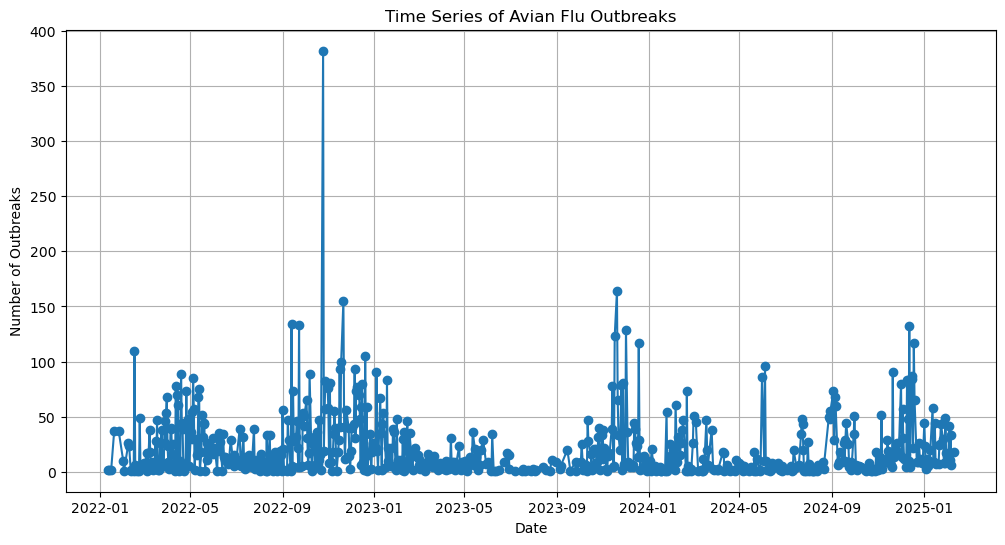

In [23]:
# Plot the outbreak trends
plt.figure(figsize=(12,6))
plt.plot(time_series, marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Number of Outbreaks")
plt.title("Time Series of Avian Flu Outbreaks")
plt.grid(True)
plt.show()


In [24]:
# Check stationarity with differencing if needed
time_series_diff = time_series.diff().dropna()

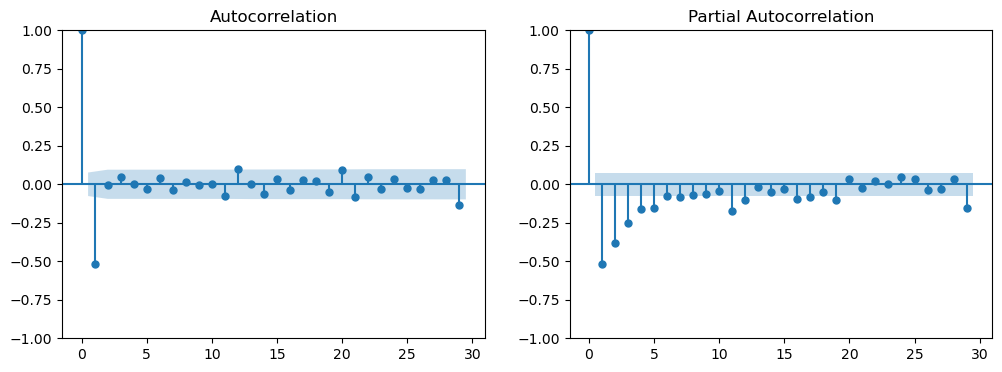

In [25]:
# Plot ACF and PACF to determine ARIMA order
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(time_series_diff, ax=axes[0])
plot_pacf(time_series_diff, ax=axes[1])
plt.show()

In [26]:
# Fit ARIMA Model (order to be determined from ACF/PACF analysis)
arima_model = ARIMA(time_series, order=(1,1,1))  # Placeholder order (p=1, d=1, q=1)
arima_result = arima_model.fit()

c:\Users\mward\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mward\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mward\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [27]:
# Forecast next 30 days
forecast = arima_result.get_forecast(steps=30)
forecast_index = pd.date_range(start=time_series.index[-1], periods=30, freq='D')
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

c:\Users\mward\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\mward\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


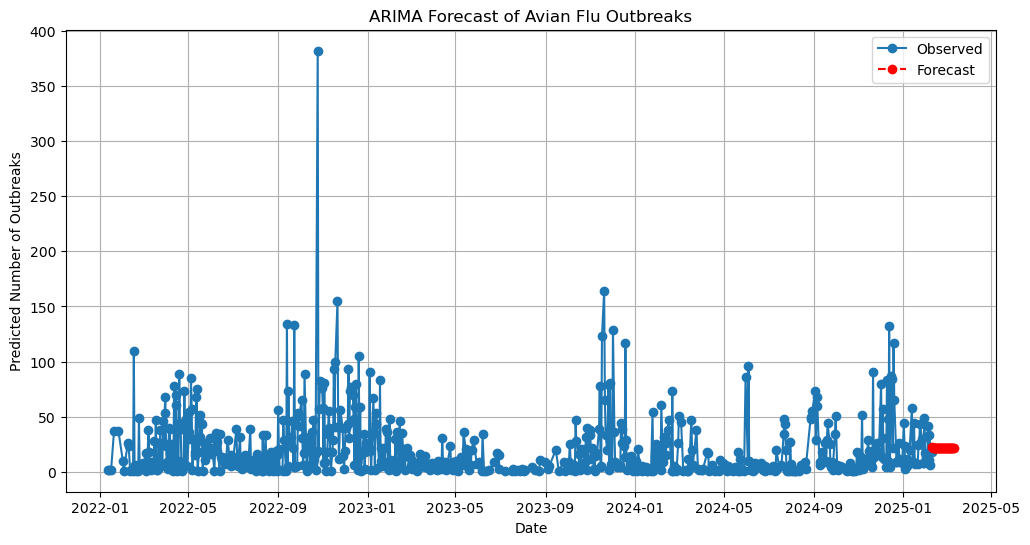

2025-02-10    22.093163
2025-02-11    21.924236
2025-02-12    21.931207
2025-02-13    21.930920
2025-02-14    21.930931
2025-02-15    21.930931
2025-02-16    21.930931
2025-02-17    21.930931
2025-02-18    21.930931
2025-02-19    21.930931
2025-02-20    21.930931
2025-02-21    21.930931
2025-02-22    21.930931
2025-02-23    21.930931
2025-02-24    21.930931
2025-02-25    21.930931
2025-02-26    21.930931
2025-02-27    21.930931
2025-02-28    21.930931
2025-03-01    21.930931
2025-03-02    21.930931
2025-03-03    21.930931
2025-03-04    21.930931
2025-03-05    21.930931
2025-03-06    21.930931
2025-03-07    21.930931
2025-03-08    21.930931
2025-03-09    21.930931
2025-03-10    21.930931
2025-03-11    21.930931
Freq: D, dtype: float64

In [28]:
# Plot forecasted outbreaks
plt.figure(figsize=(12,6))
plt.plot(time_series, label="Observed", marker='o')
plt.plot(forecast_series, label="Forecast", linestyle='dashed', marker='o', color='red')
plt.xlabel("Date")
plt.ylabel("Predicted Number of Outbreaks")
plt.title("ARIMA Forecast of Avian Flu Outbreaks")
plt.legend()
plt.grid(True)
plt.show()

# Display forecasted values
forecast_series

In [ ]:
# OTHER ALGORITHMS BELOW

In [29]:
# Create K-means model.

model = KMeans(n_clusters=3, n_init='auto', random_state=42)
model.fit(X_scaled_df)
kmeans_predictions = model.predict(X_scaled_df)
print(kmeans_predictions)

[0 0 0 ... 2 2 2]


In [30]:
# Create a copy of the DataFrame
clusters_df = X_scaled_df.copy()

# Add a column to the DataFrame that contains Clusters.
clusters_df['Cluster'] = kmeans_predictions

# Review the DataFrame
clusters_df.head()

,Days Since First Outbreak,HPAI Strain,WOAH Classification,Sampling Method,Cluster
0,-0.444844,0.314333,-0.100369,0.518533,0
1,-0.444844,0.314333,-0.100369,0.518533,0
2,-0.444844,0.314333,-0.100369,0.518533,0
3,-0.444844,0.314333,-0.100369,0.518533,0
4,-0.444844,0.314333,-0.100369,0.518533,0


<Axes: xlabel='Days Since First Outbreak', ylabel='HPAI Strain'>

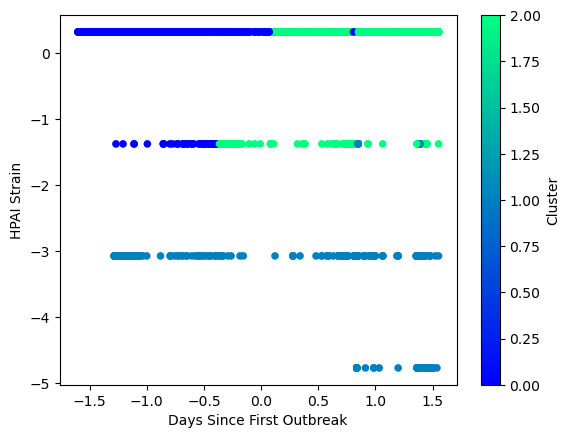

In [31]:
# Plot the data points.

clusters_df.plot.scatter(
    x='Days Since First Outbreak',
    y= 'HPAI Strain',
    c='Cluster',
    colormap='winter')

In [32]:
# Create an empty list to store the inertia values
inertia = []

# Create a list with the number of k-values to try
k = list(range(1, 11))

In [33]:
# Create a for loop to compute the inertia with each possible value of k and add the values to the inertia list.
for i in k:
    model = KMeans(n_clusters=i, n_init=10, random_state=42)
    model.fit(clusters_df)
    inertia.append(model.inertia_)

In [34]:
# Create a dictionary with the data to plot the elbow curve
elbow_data = {
    "k": k,
    "inertia": inertia
}

# Create a DataFrame with the data to plot the elbow curve
df_elbow = pd.DataFrame(elbow_data)

# Display the DataFrame
df_elbow

,k,inertia
0,1,79780.952867
1,2,49578.038758
2,3,31562.943101
3,4,22423.541386
4,5,15053.725915
5,6,11978.341446
6,7,9137.996704
7,8,7310.446917
8,9,5695.173228
9,10,5033.914699


<Axes: title={'center': 'Elbow Curve'}, xlabel='k'>

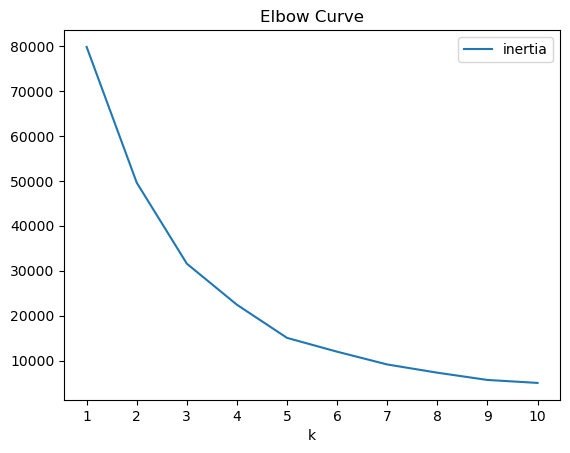

In [35]:
# Plot the Elbow curve
df_elbow.plot.line(x="k",
                   y="inertia",
                   title="Elbow Curve",
                   xticks=k)

In [36]:
# Determine the rate of decrease between each k value. 
k = elbow_data["k"]
inertia = elbow_data["inertia"]
for i in range(1, len(k)):
    percentage_decrease = (inertia[i-1] - inertia[i]) / inertia[i-1] * 100
    print(f"Percentage decrease from k={k[i-1]} to k={k[i]}: {percentage_decrease:.2f}%")

Percentage decrease from k=1 to k=2: 37.86%
Percentage decrease from k=2 to k=3: 36.34%
Percentage decrease from k=3 to k=4: 28.96%
Percentage decrease from k=4 to k=5: 32.87%
Percentage decrease from k=5 to k=6: 20.43%
Percentage decrease from k=6 to k=7: 23.71%
Percentage decrease from k=7 to k=8: 20.00%
Percentage decrease from k=8 to k=9: 22.10%
Percentage decrease from k=9 to k=10: 11.61%


In [37]:
# Fit a AgglomerativeClustering Model with five clusters
agglo_model = AgglomerativeClustering(n_clusters=5)

# Make predictions with the AgglomerativeClustering model
agglo_predictions = agglo_model.fit_predict(clusters_df)

# Previewing the predicted customer classifications for AgglomerativeClustering
agglo_predictions[-10:]

array([3, 0, 4, 1, 1, 2, 2, 4, 4, 2], dtype=int64)

In [38]:
# Fit a Birch Model with five clusters.
birch_model = Birch(n_clusters=None)
birch_model.fit(clusters_df)

# Make predictions with the Birch model
birch_predictions = birch_model.labels_

# Previewing the predicted customer classifications for BIRCH
birch_predictions[-10:]

# Look at the results
print("\nNumber of points in each cluster:")
print(pd.Series(birch_predictions).value_counts())


Number of points in each cluster:
0     4629
4     1635
5     1427
24    1370
2     1276
22     984
17     811
6      794
9      759
1      652
3      432
27     431
7      237
16     189
13     107
26     100
8      100
18      53
15      48
11      46
25      42
20      37
10      35
12      27
21      15
23      14
29      12
28       7
14       3
19       1
Name: count, dtype: int64


In [39]:
# Create a copy of the preprocessed data
cluster_predictions_df = clusters_df.copy()

# Add class columns with the labels to the new DataFrame

cluster_predictions_df["kmeans-segments"] = kmeans_predictions
cluster_predictions_df["agglomerative-segments"] = agglo_predictions
cluster_predictions_df["birch-segments"] = birch_predictions
cluster_predictions_df[['kmeans-segments','agglomerative-segments', 'birch-segments']].head(3)

,kmeans-segments,agglomerative-segments,birch-segments
0,0,1,0
1,0,1,0
2,0,1,0


<Axes: xlabel='Days Since First Outbreak', ylabel='HPAI Strain'>

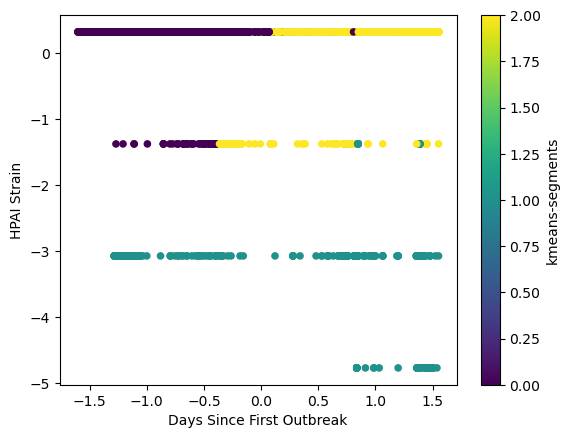

In [40]:
# Plot the kmeans clusters. 
cluster_predictions_df.plot.scatter(
    x='Days Since First Outbreak',
    y='HPAI Strain',
    c='kmeans-segments',
    colormap='viridis')

<Axes: xlabel='Days Since First Outbreak', ylabel='HPAI Strain'>

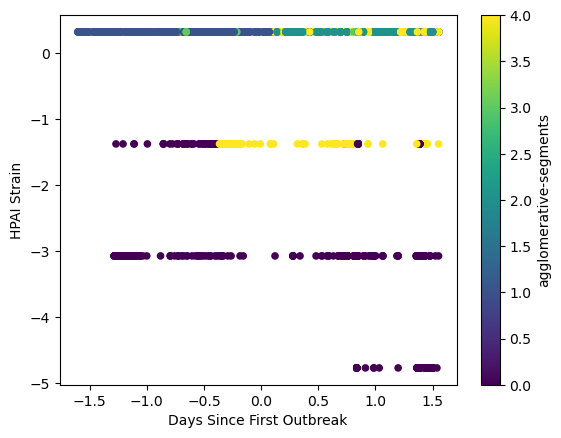

In [41]:
# Plot the agglomerative clusters using the limit_bal and age columns. 
cluster_predictions_df.plot.scatter(
    x='Days Since First Outbreak',
    y='HPAI Strain',
    c='agglomerative-segments',
    colormap='viridis')

<Axes: xlabel='Days Since First Outbreak', ylabel='HPAI Strain'>

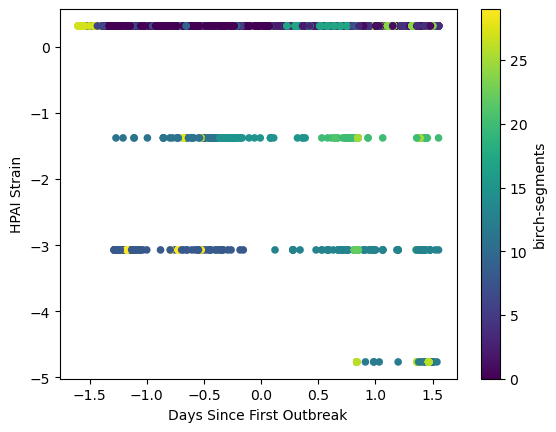

In [42]:
# Plot the birch clusters.

cluster_predictions_df.plot.scatter(
    x='Days Since First Outbreak',
    y='HPAI Strain',
    c='birch-segments',
    colormap='viridis')

In [43]:
# Create a list to store values and the values of k
score_kmeans = []
score_agglomerative = []
score_birch = []

# Create a list to set the range of k values to test
k = list(range(2, 11))

In [44]:
from sklearn import metrics
# For each model, we iterate through the different cluster count (`i`). 
# Then, calculate the variance ratio for each algorithm, given that specified cluster count.

for i in k:
    # Kmeans variance and score
    k_model = KMeans(n_clusters=i, n_init='auto',random_state=0)
    k_model.fit(clusters_df)
    labels = k_model.labels_
    score = metrics.calinski_harabasz_score(clusters_df, labels)    
    score_kmeans.append(score)
    
    # AgglomerativeClustering variance and score
    agglo_model = AgglomerativeClustering(n_clusters=i)
    labels = agglo_model.fit_predict(clusters_df)
    score = metrics.calinski_harabasz_score(clusters_df, labels)    
    score_agglomerative.append(score)    
    
    # Birch variance and score
    birch_model = Birch(n_clusters=i)
    birch_model.fit(clusters_df)
    labels = birch_model.labels_
    score = metrics.calinski_harabasz_score(clusters_df, labels)    
    score_birch.append(score)

In [45]:
# Display the scores. 
display(score_kmeans)
display(score_agglomerative)
display(score_birch)

[9911.558733651907,
 6174.94714387819,
 10220.47470213834,
 12614.419603400655,
 18342.046424088458,
 19307.32215630454,
 21017.77119400347,
 26195.24488019038,
 25026.106747159483]

[9705.549380725732,
 11956.725729226773,
 13442.884931219442,
 16849.14373263059,
 17988.693441540094,
 20629.214648207275,
 22363.05496884571,
 25413.152349623942,
 25668.474774903214]

[3532.0040198082106,
 5316.1508370688725,
 13841.231469097027,
 10537.807814694726,
 10097.785862844681,
 15281.754084413737,
 13447.886665085527,
 15746.431991712227,
 15299.386548294073]

In [46]:
# Create dictionary for easy reference
dataframes = {
    "hpai-flocks": flocks_df,
    "hpai-livestock": livestock_df,
    "hpai-mammals": mammals_df,
    "hpai-wild-birds1": wild_birds_df
}

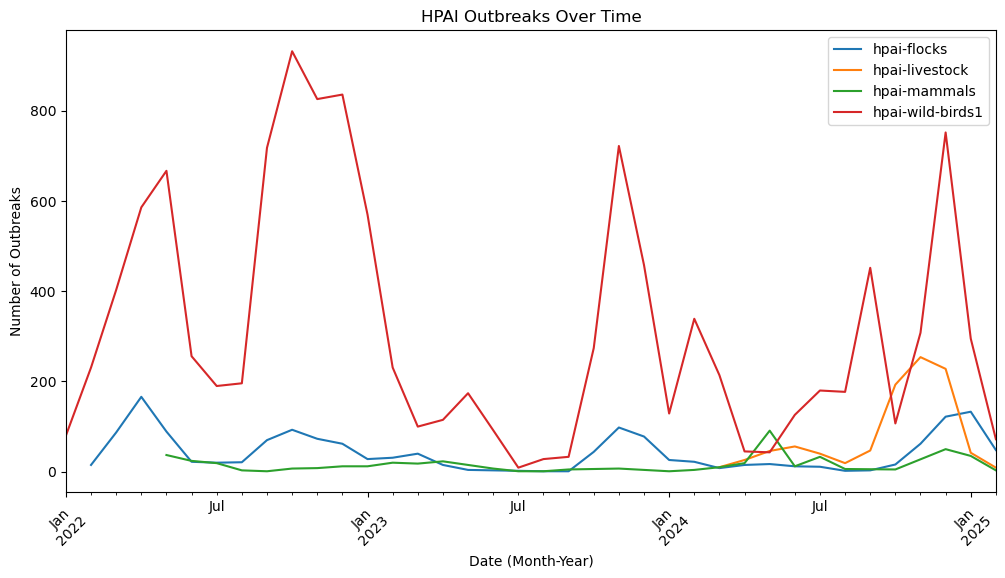

In [47]:
# 1. HPAI Outbreaks Over Time
plt.figure(figsize=(12, 6))
for name, df in dataframes.items():
    df["Outbreak Date"].dt.to_period("M").value_counts().sort_index().plot(label=name)

plt.title("HPAI Outbreaks Over Time")
plt.xlabel("Date (Month-Year)")
plt.ylabel("Number of Outbreaks")
plt.legend()
plt.xticks(rotation=45)
plt.show()

C:\Users\mward\AppData\Local\Temp\ipykernel_16560\1280911493.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_counts.index, y=state_counts.values, palette="coolwarm")


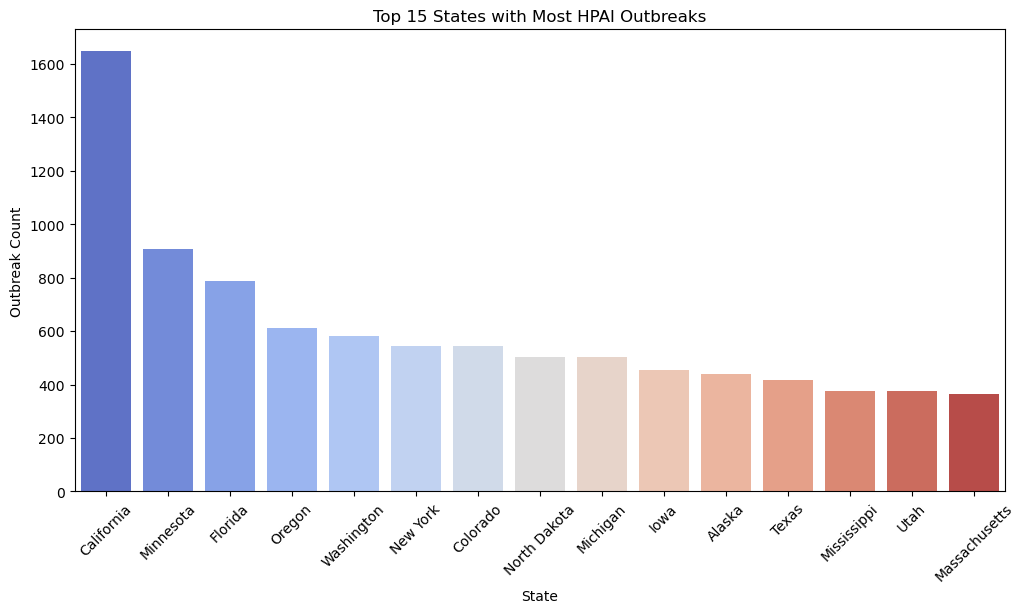

In [48]:
# 2. Top 15 States with Most HPAI Outbreaks
plt.figure(figsize=(12, 6))
state_counts = pd.concat([df["State"] for df in dataframes.values()]).value_counts()[:15]
sns.barplot(x=state_counts.index, y=state_counts.values, palette="coolwarm")
plt.title("Top 15 States with Most HPAI Outbreaks")
plt.xlabel("State")
plt.ylabel("Outbreak Count")
plt.xticks(rotation=45)
plt.show()

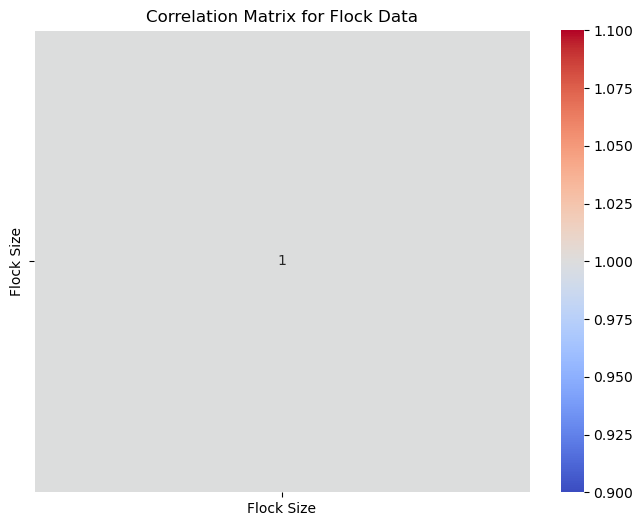

In [49]:
# 3. Correlation Matrix for Flock Data
plt.figure(figsize=(8, 6))
sns.heatmap(flocks_df.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix for Flock Data")
plt.show()

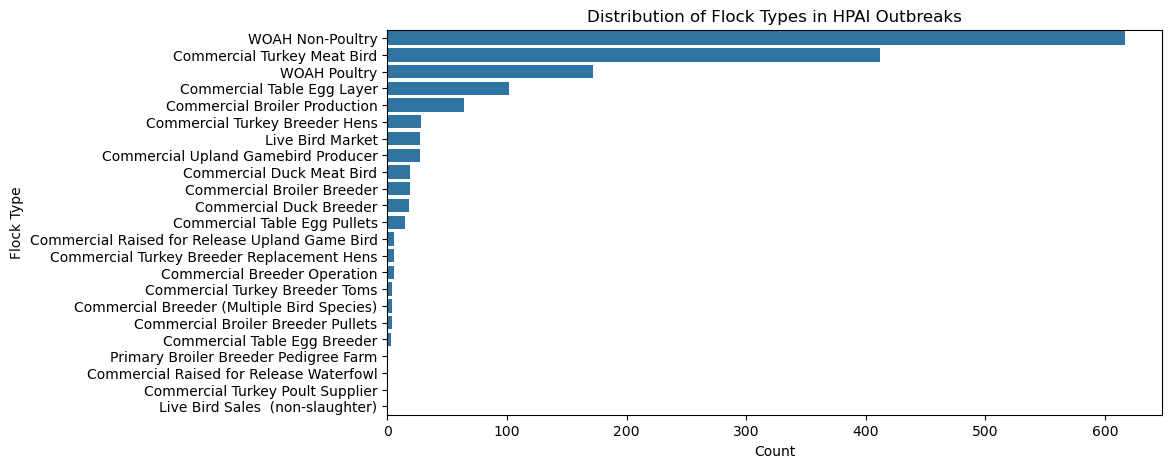

In [50]:
# Flock Type Distribution (Only for Flocks Data)
plt.figure(figsize=(10, 5))
sns.countplot(y=dataframes["hpai-flocks"]["Flock Type"], order=dataframes["hpai-flocks"]["Flock Type"].value_counts().index)
plt.title("Distribution of Flock Types in HPAI Outbreaks")
plt.xlabel("Count")
plt.ylabel("Flock Type")
plt.show()

C:\Users\mward\AppData\Local\Temp\ipykernel_16560\2743845187.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_species.values, y=top_species.index, palette="viridis")


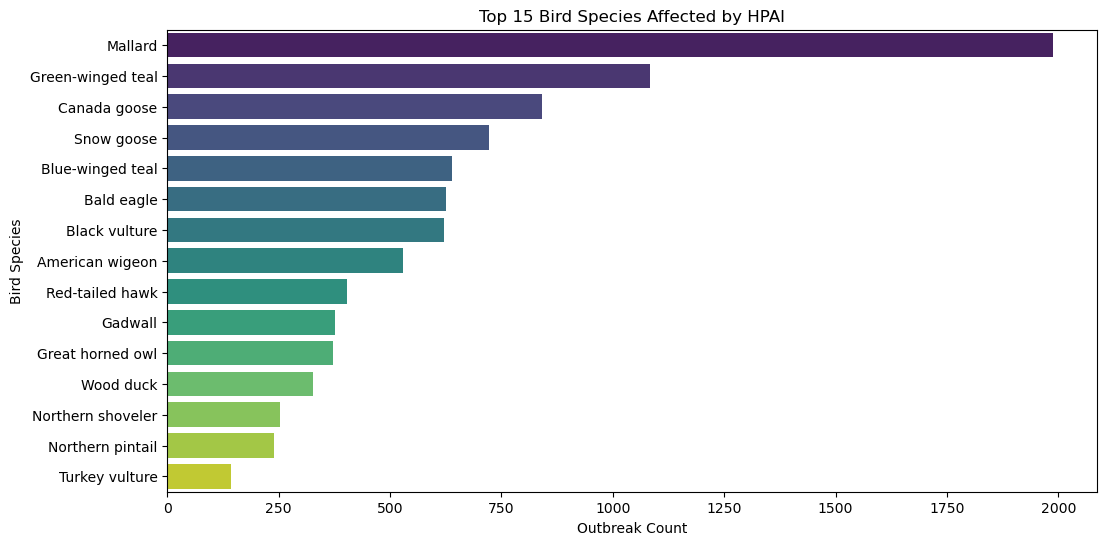

In [51]:
# Distribution of Species Affected in Wild Birds Dataset
plt.figure(figsize=(12, 6))
top_species = dataframes["hpai-wild-birds1"]["Bird Species"].value_counts()[:15]
sns.barplot(x=top_species.values, y=top_species.index, palette="viridis")
plt.title("Top 15 Bird Species Affected by HPAI")
plt.xlabel("Outbreak Count")
plt.ylabel("Bird Species")
plt.show()

C:\Users\mward\AppData\Local\Temp\ipykernel_16560\2111612854.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=strain_counts.values, y=strain_counts.index, palette="magma")


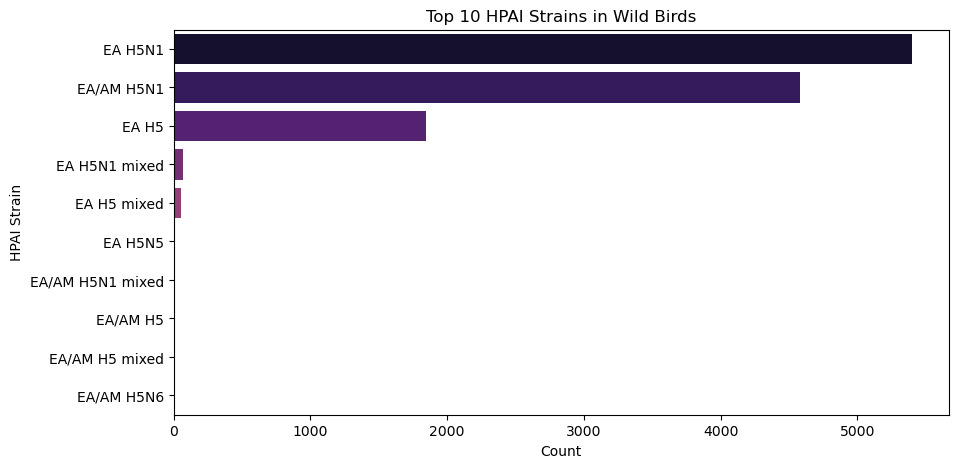

In [52]:
# 6. HPAI Strain Frequency in Wild Birds
plt.figure(figsize=(10, 5))
strain_counts = wild_birds_df["HPAI Strain"].value_counts()[:10]
sns.barplot(x=strain_counts.values, y=strain_counts.index, palette="magma")
plt.title("Top 10 HPAI Strains in Wild Birds")
plt.xlabel("Count")
plt.ylabel("HPAI Strain")
plt.show()

C:\Users\mward\AppData\Local\Temp\ipykernel_16560\2324550223.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mammal_species_counts.values, y=mammal_species_counts.index, palette="Blues_r")


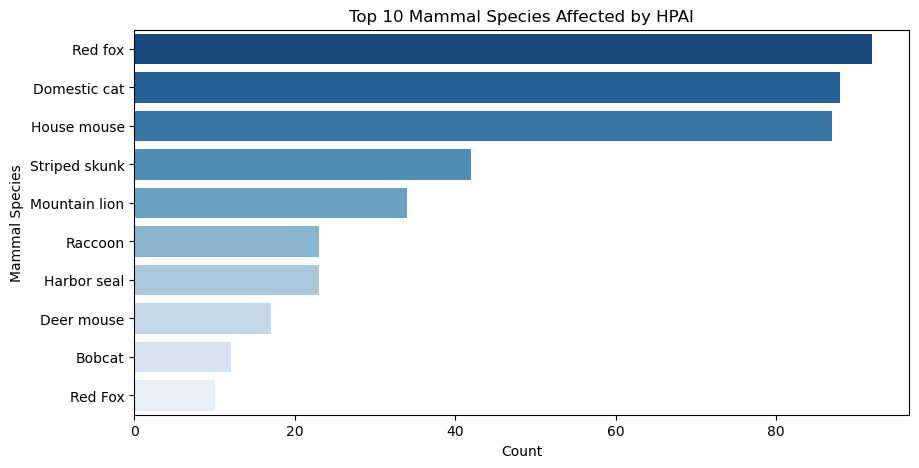

In [53]:
# 7. Mammal Species Affected
plt.figure(figsize=(10, 5))
mammal_species_counts = mammals_df["Species"].value_counts()[:10]
sns.barplot(x=mammal_species_counts.values, y=mammal_species_counts.index, palette="Blues_r")
plt.title("Top 10 Mammal Species Affected by HPAI")
plt.xlabel("Count")
plt.ylabel("Mammal Species")
plt.show()

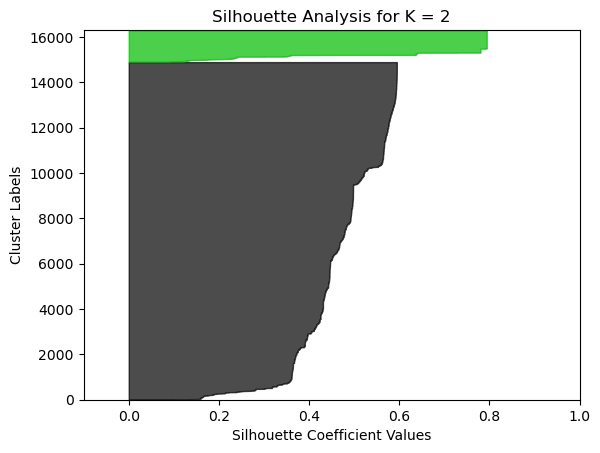

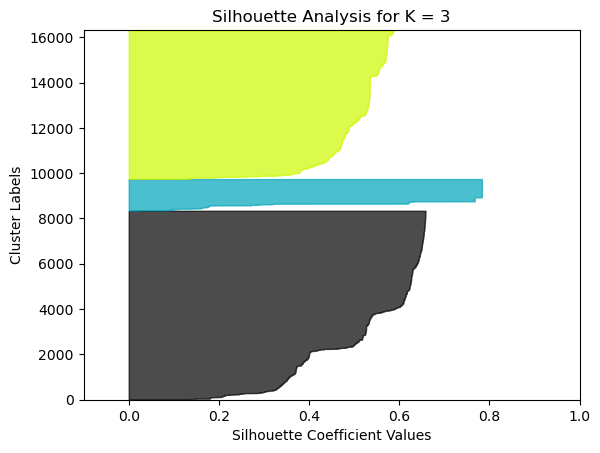

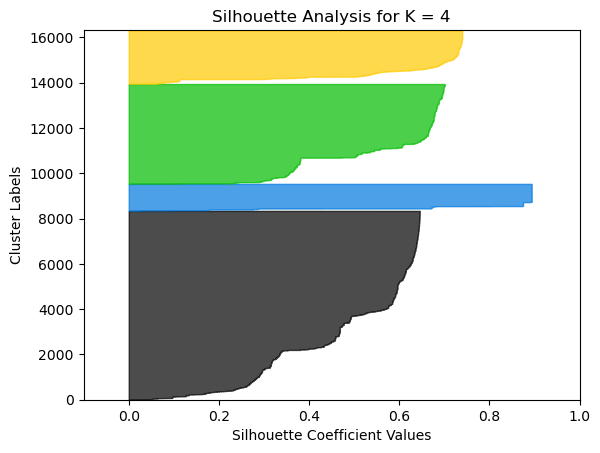

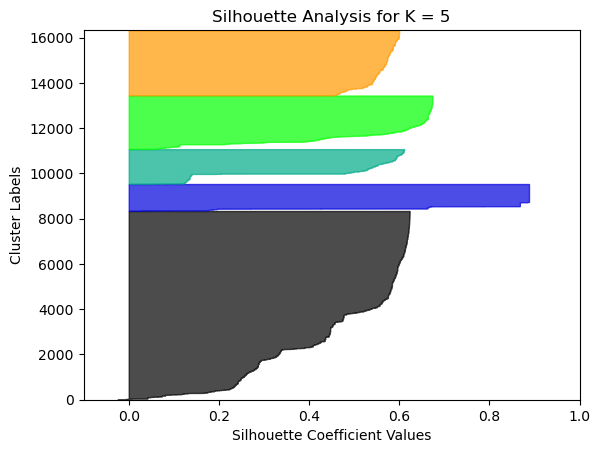

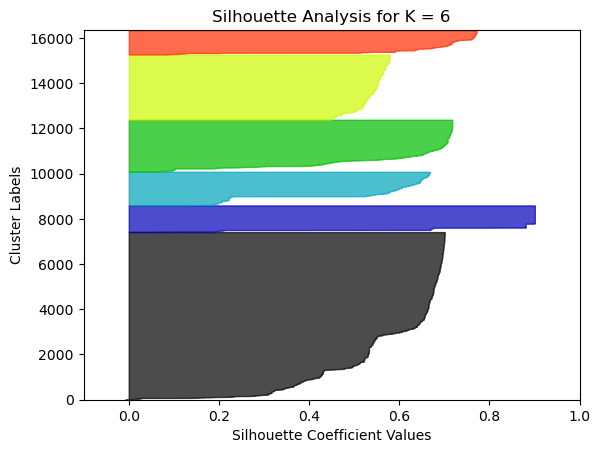

In [54]:
# Cluster Silhouette Analysis

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    fig, ax = plt.subplots()
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(clusters_df) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(clusters_df)
    
    silhouette_avg = silhouette_score(clusters_df, cluster_labels)
    sample_silhouette_values = silhouette_samples(clusters_df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)

        y_lower = y_upper + 10

    ax.set_title(f"Silhouette Analysis for K = {n_clusters}")
    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster Labels")
    plt.show()


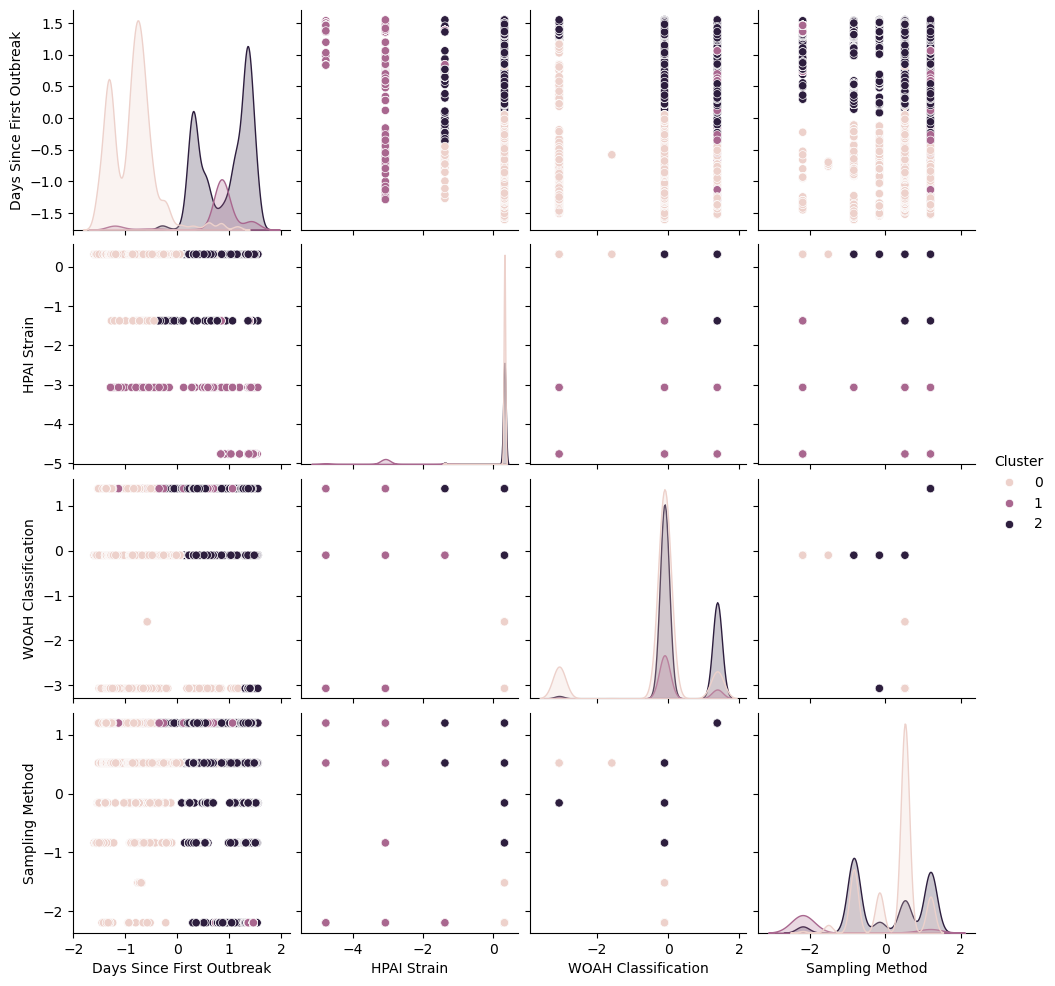

In [55]:
# Pair Plot for Clusters

import seaborn as sns

clusters_df["Cluster"] = kmeans_predictions  # Assign cluster labels
sns.pairplot(clusters_df, hue="Cluster", diag_kind="kde")
plt.show()


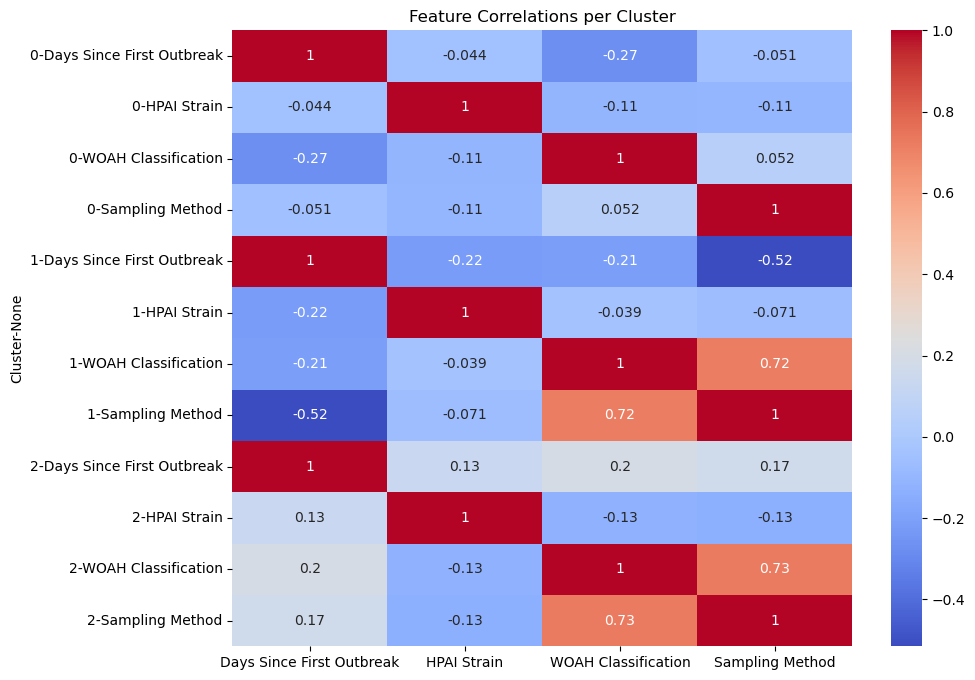

In [56]:
# Heatmap of Feature Correlations by Cluster

cluster_corrs = clusters_df.groupby("Cluster").corr()
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_corrs, cmap="coolwarm", annot=True)
plt.title("Feature Correlations per Cluster")
plt.show()
